In [1]:
import os
import requests
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection

import torch
import torch.nn.functional as F
from torch import nn
from torch.nn.utils import prune
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
SEED = 42
RNG = torch.Generator().manual_seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

Running on device: CUDA


In [2]:
import ssl

# Create an unverified SSL context
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=True, download=False, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=1)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=False, download=False, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=1)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=1)

# download the forget and retain index split
local_path = "../example notebooks/forget_idx.npy"
# if not os.path.exists(local_path):
#     response = requests.get(
#         "https://storage.googleapis.com/unlearning-challenge/" + local_path
#     )
#     open(local_path, "wb").write(response.content)
forget_idx = np.load(local_path)

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=128, shuffle=False, num_workers=1
)
# retain_loader = torch.utils.data.DataLoader(
#     retain_set, batch_size=128, shuffle=True, num_workers=1, generator=RNG
# )

In [4]:
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=128, shuffle=False, num_workers=1
)

In [23]:
local_path = "../example notebooks/weights/weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE) #43Mbs

# load model with pre-trained weights
model = resnet18(weights=None, num_classes=10)
model.load_state_dict(weights_pretrained)
model.to(DEVICE)
model.eval();

In [24]:
def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total

In [25]:
def global_unstructure_prune(model, pruning_amount=0.2):

    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, 'weight'))

    # Global pruning
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=pruning_amount
    )

    # Make the pruning permanent
    for module, param_name in parameters_to_prune:
        prune.remove(module, param_name)

In [26]:
def plot_teacher_student_outputs(teacher_logits, student_logits):
    teacher_probs = torch.nn.functional.softmax(teacher_logits, dim=0).cpu().numpy()
    student_probs = torch.nn.functional.softmax(student_logits, dim=0).cpu().numpy()
    plt.plot(teacher_probs, 'ko', label='teacher')
    plt.plot(student_probs, 'ro', label='student')
    plt.legend()
    plt.yscale('log')
    plt.show()

## Teacher

In [27]:
'''
Shuffle retain data
'''

data_list = []
label_list = []

for data, label in retain_loader:
    data_list.append(data)
    label_list.append(label)
    
all_data = torch.cat(data_list, 0)
all_labels = torch.cat(label_list, 0)
    
combined = list(zip(all_data, all_labels))
random.shuffle(combined)
shuffled_data, shuffled_labels = zip(*combined)

shuffled_data = torch.stack(shuffled_data)
shuffled_labels = torch.stack(shuffled_labels)

shuffled_dataset = TensorDataset(shuffled_data, shuffled_labels)
retain_loader = DataLoader(shuffled_dataset, batch_size=128, shuffle=False)

In [28]:
teacher_logits_tensor = torch.zeros(len(retain_loader.dataset), 10)

start_idx = 0
with torch.no_grad():
    for (inputs, labels) in retain_loader:
        end_idx = start_idx + inputs.shape[0]
        outputs = model(inputs.to(DEVICE))
        teacher_logits_tensor[start_idx:end_idx] = outputs.cpu()
        start_idx = end_idx

# Create a dataloader
logit_loader = DataLoader(teacher_logits_tensor, batch_size=128, shuffle=False)

## Student

In [29]:
# Apply pruning
pct = 0.95
global_unstructure_prune(model, pct)

In [30]:
student_logits = torch.zeros(len(retain_loader.dataset), 10)

start_idx = 0
with torch.no_grad():
    for (inputs, labels) in retain_loader:
        end_idx = start_idx + inputs.shape[0]
        outputs = model(inputs.to(DEVICE))
        student_logits[start_idx:end_idx] = outputs.cpu()
        start_idx = end_idx

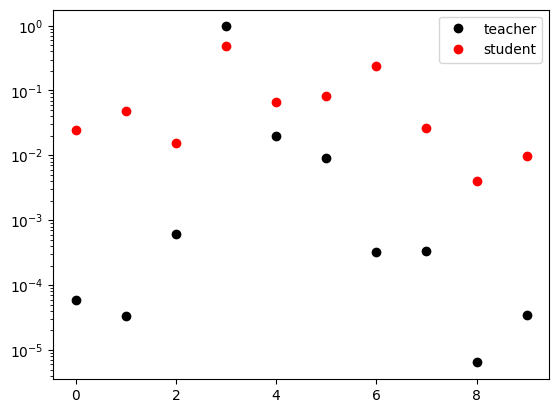

In [31]:
plot_teacher_student_outputs(teacher_logits_tensor[3], student_logits[3])

## Knowledge distillation

In [32]:
alpha = 0.1
n_classes = 10
T = 2.0

In [33]:
initial_lr = 0.01/2
epochs = 1

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9, weight_decay=5e-4)

In [34]:
model.train()

for ep in range(epochs):

    for (inputs, targets), teacher_logits in zip(retain_loader, logit_loader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        teacher_logits = teacher_logits.to(DEVICE)

        optimizer.zero_grad()
        
        # Forward pass student
        student_logits = model(inputs)

        # Calculate soft labels from teacher
        teacher_probs = F.softmax(teacher_logits/T, dim=1)

        # Compute distillation loss
        student_log_probs = F.log_softmax(student_logits/T, dim=1)
        distillation_loss = F.kl_div(student_log_probs, teacher_probs, reduction='batchmean') * (T * T)

        # Perform label smoothing
        labels_one_hot = F.one_hot(labels, n_classes).float()
        labels_smooth = (1-alpha) * labels_one_hot + (alpha/n_classes)

        # Compute the classification loss
        classification_loss = criterion(student_logits, targets)

        loss = 0.9*distillation_loss + 0.1*classification_loss
        loss.backward()
        optimizer.step()

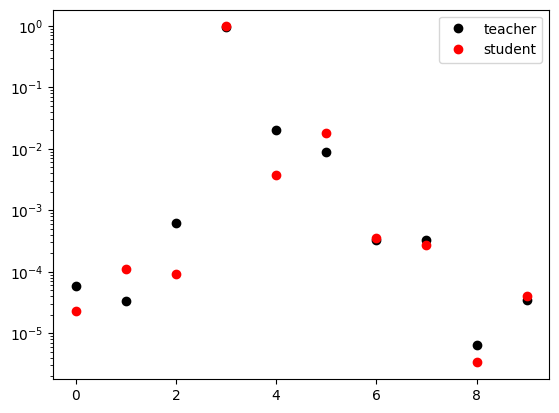

In [35]:
student_logits = torch.zeros(len(retain_loader.dataset), 10)

start_idx = 0
with torch.no_grad():
    for (inputs, labels) in retain_loader:
        end_idx = start_idx + inputs.shape[0]
        outputs = model(inputs.to(DEVICE))
        student_logits[start_idx:end_idx] = outputs.cpu()
        start_idx = end_idx

plot_teacher_student_outputs(teacher_logits_tensor[3], student_logits[3])

## Evaluation

In [36]:
print(f"Retain set accuracy: {100.0 * accuracy(model, retain_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(model, forget_loader):0.1f}%")
print(f"Val set accuracy: {100.0 * accuracy(model, val_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model, test_loader):0.1f}%")

Retain set accuracy: 97.7%
Forget set accuracy: 96.1%
Val set accuracy: 86.5%
Test set accuracy: 86.8%


## MIA

In [37]:
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

In [38]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

In [39]:
ft_forget_losses = compute_losses(model, forget_loader)
ft_test_losses = compute_losses(model, test_loader)

# make sure we have a balanced dataset for the MIA
assert len(ft_test_losses) == len(ft_forget_losses)

ft_samples_mia = np.concatenate((ft_test_losses, ft_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(ft_test_losses) + [1] * len(ft_forget_losses)

In [40]:
ft_mia_scores = simple_mia(ft_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {ft_mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.553 on forgotten vs unseen images
